# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from torchsummary import summary


from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle

from sklearn.metrics import confusion_matrix
import seaborn as sn

plt.style.use('ggplot')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare and Visualize Data

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [4]:
# run this cell to download and prepare data
from data_utils import download_data, prepare_data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.head()

efigi_png downloaded!
efigi_tables downloaded!


,name,class_name,class_label
0,PGC0000212,Spirals,2
1,PGC0000218,Spirals,2
2,PGC0000243,Lenticulars,1
3,PGC0000255,Spirals,2
4,PGC0000281,Spirals,2


## Visualizing 4 samples from each class

class Ellipticals has 289 pictures.
class Lenticulars has 537 pictures.
class Spirals has 3315 pictures.
class Irregulars has 317 pictures.


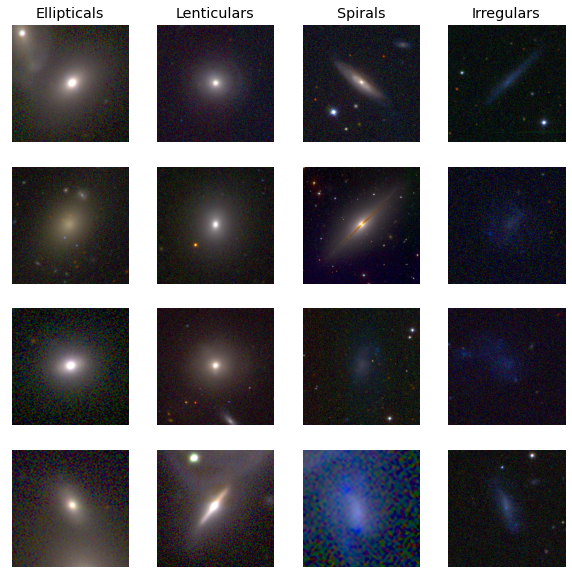

In [5]:
NUM_CLASSES = 4
SAMPLE_COUNT = 4
samples = []
classes = []
class_sizes = []

fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(NUM_CLASSES):
    class_samples = df[df['class_label'] == i]
    class_name = class_samples.iloc[0]['class_name']
    class_size = len(class_samples)
    print(f'class {class_name} has {class_size} pictures.')
    classes.append(class_name)
    class_sizes.append(class_size)


    for j in range(SAMPLE_COUNT):
        sample = class_samples.iloc[j]
        image = plt.imread('/content/efigi-1.6/png/' + sample['name'] + '.png')
        axs[j, i].imshow(image)
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        if j == 0:
            axs[j, i].set_title(classes[i])

```
class Ellipticals has 289 pictures.
class Lenticulars has 537 pictures.
class Spirals has 3315 pictures.
class Irregulars has 317 pictures.
```
Spirals class has a lot more pictures than other classes. In fact if our model just outputs 2 (predicting all samples as spirals) it'll have about 74% accuracy. We will first try to train a model on the dataset with no modifications and see what happens.


# Defining Dataset
Our dataset basically returns a transformed version of an image(x) in combination with its class label(y)

In [6]:
class GalaxyDataSet(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.df.iloc[idx]

        image_name, y = sample['name'], sample['class_label']
        x = plt.imread(self.root_dir + image_name + '.png')
        
        if self.transform:
            x = self.transform(x)
        return x, y

In [7]:
def calc_metrics(data_loader, loss_fn, model):
    model.eval()
    accuracy = 0.0
    loss = 0
    tot_labels = []
    tot_pred = []
    steps = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            pred = torch.argmax(outputs, 1)

            accuracy += (pred == labels).sum().item()
            loss += loss_fn(outputs, labels)
            steps += 1
    loss /= steps
    accuracy = (100 * accuracy / len(data_loader.dataset))

    return loss.item(), accuracy

def train(model_dict, epochs):
    model, optimizer, scheduler, loss_fn = model_dict['model'], model_dict['optimizer'], model_dict['scheduler'], model_dict['loss']
    train_loader, test_loader = loaders['train'], loaders['test']
    metrics = {
        'train loss': [], 'test loss': [],
        'train acc': [], 'test acc': [],
        'train f1': [], 'test f1': []
    }
    metrics['train loss'] = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()

        train_loss, train_acc = calc_metrics(train_loader, loss_fn, model)
        test_loss, test_acc = calc_metrics(test_loader, loss_fn, model)
        print("Epoch ", epoch + 1)
        print(f"Training: Loss = {train_loss}, Acc = {train_acc}")
        print(f"Testing: Loss = {test_loss}, Acc = {test_acc}")
        print("------------------------------------------------")
        metrics['train loss'].append(train_loss)
        metrics['test loss'].append(test_loss)
        metrics['train acc'].append(train_acc)
        metrics['test acc'].append(test_acc)
    return metrics
def show_metrics(metrics):
    epochs = len(metrics['train loss'])
    x = [i + 1 for i in range(epochs)]
    plt.plot(x, metrics['train loss'], color='r', label='train')
    plt.plot(x, metrics['test loss'], color='b', label='test')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch")
    plt.legend()
    plt.show()

    plt.plot(x, metrics['train acc'], color='r', label='train')
    plt.plot(x, metrics['test acc'], color='b', label='test')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epoch")
    plt.legend()
    plt.show()

def plot_confusion(model):
    preds = []
    labels = []
    model.eval()
    with torch.no_grad():
        for images, label in loaders['test']:
            image = images.to(device)
            labels += label
            output = model(image)
            pred = torch.argmax(output, 1)
            preds += pred
    labels = [label.item() for label in labels]
    preds = [pred.item() for pred in preds]
    df_cm = pd.DataFrame(confusion_matrix(labels, preds))
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.title("Confusion Matrix")
    plt.show()

## Dataset and Dataloader

In [8]:
PATH = '/content/efigi-1.6/png/' # Change this to path of the directory in which U have the pictures.

dataset = GalaxyDataSet(df, PATH, transforms.ToTensor())

In [9]:
BATCH_SIZE = 16
TEST_SIZE = 0.2

train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=TEST_SIZE)

loaders = {
    'train': DataLoader(Subset(dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    'test': DataLoader(Subset(dataset, test_idx), batch_size=BATCH_SIZE, num_workers=2)
}

# First Model
In this model we're going to use a MLP and train it on the raw dataset.

## Model Architecture


In [10]:
class ClassifierModel(nn.Module):
    def __init__(self, dims):
        super(ClassifierModel, self).__init__()

        self.layers = nn.ModuleList()
        for input_dim, output_dim in zip(dims[:-1], dims[1:]):
            self.layers.append(nn.Linear(input_dim, output_dim))

    def forward(self, x):
        x = torch.flatten(x, 1)
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))

        return F.softmax(self.layers[-1](x), dim=-1)

In [11]:
input_dim = (255, 255, 3)
flat_input_dim = np.multiply.reduce(input_dim)
output_dim = NUM_CLASSES
dims = [flat_input_dim, 256, 128, 32, output_dim]
model1 = ClassifierModel(dims)
model1.to(device)

optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.0001)
scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer1, gamma=0.95)
loss1 = nn.CrossEntropyLoss()

first_model = {
    'model': model1,
    'optimizer': optimizer1,
    'scheduler': scheduler1,
    'loss': loss1
}
summary(first_model['model'], input_dim)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]      49,939,456
            Linear-2                  [-1, 128]          32,896
            Linear-3                   [-1, 32]           4,128
            Linear-4                    [-1, 4]             132
Total params: 49,976,612
Trainable params: 49,976,612
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.74
Forward/backward pass size (MB): 0.00
Params size (MB): 190.65
Estimated Total Size (MB): 191.39
----------------------------------------------------------------


In [12]:
first_metrics = train(first_model, 5)

Epoch  1
Training: Loss = 0.9974273443222046, Acc = 74.62142456533931
Testing: Loss = 1.0111756324768066, Acc = 73.31838565022422
------------------------------------------------
Epoch  2
Training: Loss = 0.9975563883781433, Acc = 74.62142456533931
Testing: Loss = 1.0111559629440308, Acc = 73.31838565022422
------------------------------------------------
Epoch  3
Training: Loss = 0.9975134134292603, Acc = 74.62142456533931
Testing: Loss = 1.011154055595398, Acc = 73.31838565022422
------------------------------------------------
Epoch  4
Training: Loss = 0.99747234582901, Acc = 74.62142456533931
Testing: Loss = 1.0111536979675293, Acc = 73.31838565022422
------------------------------------------------
Epoch  5
Training: Loss = 0.9974721074104309, Acc = 74.62142456533931
Testing: Loss = 1.011153221130371, Acc = 73.31838565022422
------------------------------------------------


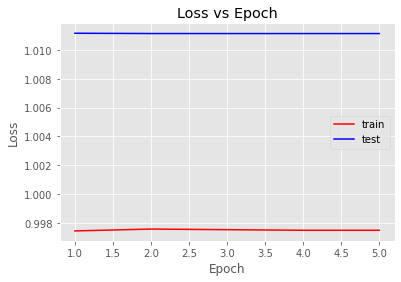

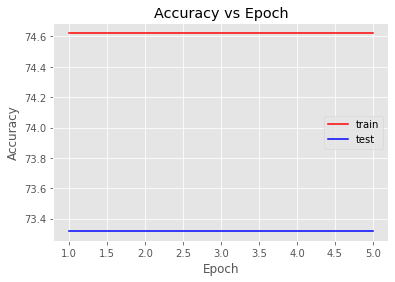

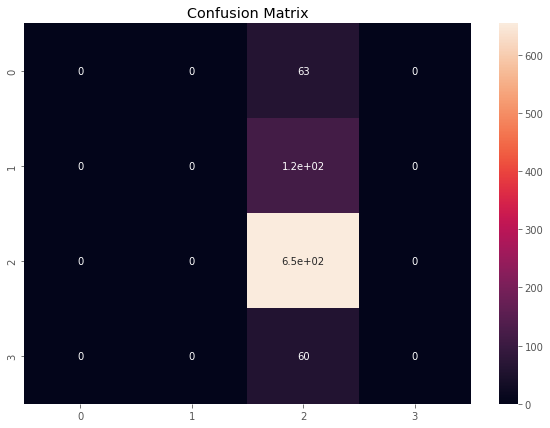

In [13]:
show_metrics(first_metrics)
plot_confusion(first_model['model'])

#Second Attempt:
This time, we're going to use weighted cross entropy loss, and weight of each class is inversely porportional to it's frequency in the dataset.

In [20]:
sum_sizes = sum(class_sizes)
weights = sum_sizes / torch.tensor(class_sizes)
loss2 = nn.CrossEntropyLoss(weight=weights.to(device))

In [27]:
torch.manual_seed(0)
model2 = ClassifierModel(dims)
model2.to(device)

optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0001)
scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer2, gamma=0.95)



second_model = {
    'model': model2,
    'optimizer': optimizer2,
    'scheduler': scheduler2,
    'loss': loss2
}

In [28]:
second_metrics = train(second_model, 20)

Epoch  1
Training: Loss = 1.2315917015075684, Acc = 50.84127874369041
Testing: Loss = 1.2425771951675415, Acc = 51.34529147982063
------------------------------------------------
Epoch  2
Training: Loss = 1.1302310228347778, Acc = 73.27537857543466
Testing: Loss = 1.1675211191177368, Acc = 70.73991031390135
------------------------------------------------
Epoch  3
Training: Loss = 1.061470866203308, Acc = 65.5356141334829
Testing: Loss = 1.1317956447601318, Acc = 61.210762331838566
------------------------------------------------
Epoch  4
Training: Loss = 1.0019441843032837, Acc = 70.72349971957375
Testing: Loss = 1.1049546003341675, Acc = 65.02242152466367
------------------------------------------------
Epoch  5
Training: Loss = 0.9853166937828064, Acc = 70.35894559730791
Testing: Loss = 1.0795488357543945, Acc = 63.34080717488789
------------------------------------------------
Epoch  6
Training: Loss = 0.9193364977836609, Acc = 81.9125070106562
Testing: Loss = 1.0658040046691895, A

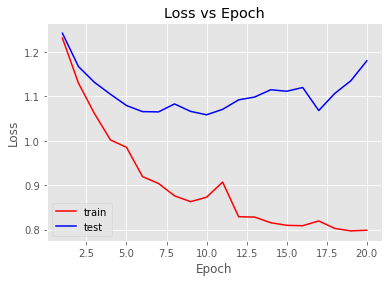

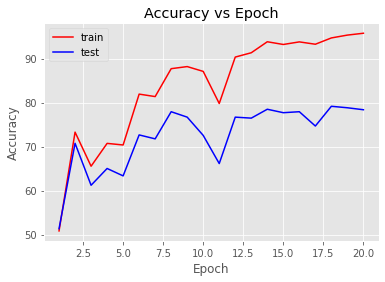

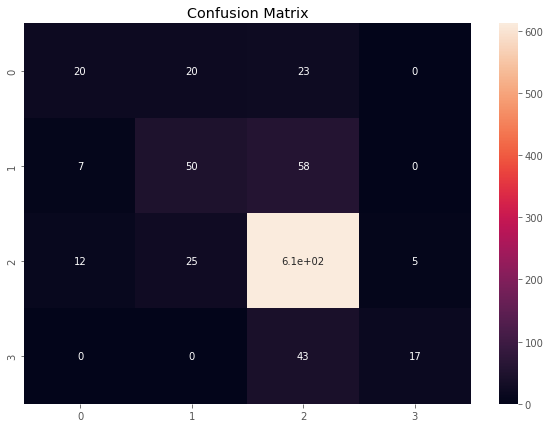

In [29]:
show_metrics(second_metrics)
plot_confusion(second_model['model'])

#Third Attempt
In our third and last attempt, we're going to implement a wellknown CNN model called ResNet.

In [ ]:
from torch.nn import Conv2d, MaxPool2d, ReLU, LogSoftmax, AdaptiveAvgPool2d

class ResidualClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.res1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.seq2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.res2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.seq3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.res3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.seq3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=61504, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=4),
        )


    def forward(self, x):
        y1 = self.seq1(x)
        y2 = self.res1(y1) + y1
        y3 = self.seq2(y2)
        y4 = self.res2(y3) + y3
        y5 = self.seq3(y4)
        return y5

In [31]:
#Same as before
sum_sizes = sum(class_sizes)
weights = sum_sizes / torch.tensor(class_sizes)
loss3 = nn.CrossEntropyLoss(weight=weights.to(device))

In [34]:
torch.manual_seed(0)
model3 = ResidualClassifier()
model3.to(device)

optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.0001)
scheduler3 = torch.optim.lr_scheduler.ExponentialLR(optimizer3, gamma=0.95)



third_model = {
    'model': model3,
    'optimizer': optimizer3,
    'scheduler': scheduler3,
    'loss': loss3
}
summary(model3, (3, 255, 255))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 255, 255]             896
              ReLU-2         [-1, 32, 255, 255]               0
         MaxPool2d-3         [-1, 32, 127, 127]               0
            Conv2d-4         [-1, 32, 127, 127]           9,248
              ReLU-5         [-1, 32, 127, 127]               0
            Conv2d-6         [-1, 32, 127, 127]           9,248
              ReLU-7         [-1, 32, 127, 127]               0
         MaxPool2d-8           [-1, 32, 63, 63]               0
            Conv2d-9           [-1, 64, 63, 63]          18,496
             ReLU-10           [-1, 64, 63, 63]               0
           Conv2d-11           [-1, 64, 63, 63]          36,928
             ReLU-12           [-1, 64, 63, 63]               0
           Conv2d-13           [-1, 64, 63, 63]          36,928
             ReLU-14           [-1, 64,

In [35]:
third_metrics = train(third_model, 20)

Epoch  1
Training: Loss = 0.957726776599884, Acc = 50.1402131239484
Testing: Loss = 0.9411246180534363, Acc = 52.130044843049326
------------------------------------------------
Epoch  2
Training: Loss = 0.927324116230011, Acc = 65.03084688726865
Testing: Loss = 0.8994802236557007, Acc = 63.90134529147982
------------------------------------------------
Epoch  3
Training: Loss = 0.763230562210083, Acc = 58.94559730790802
Testing: Loss = 0.7466477155685425, Acc = 61.09865470852018
------------------------------------------------
Epoch  4
Training: Loss = 0.6397987604141235, Acc = 67.49859786876051
Testing: Loss = 0.6484083533287048, Acc = 67.37668161434978
------------------------------------------------
Epoch  5
Training: Loss = 0.613395631313324, Acc = 80.87492989343802
Testing: Loss = 0.6391221880912781, Acc = 80.94170403587444
------------------------------------------------
Epoch  6
Training: Loss = 0.5423527956008911, Acc = 75.88334268087493
Testing: Loss = 0.5906183123588562, Acc

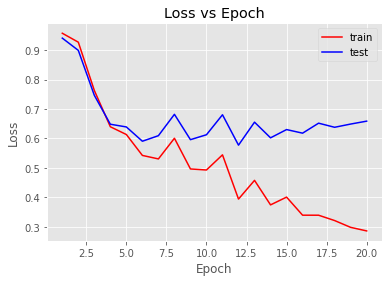

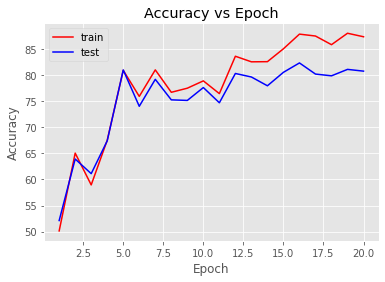

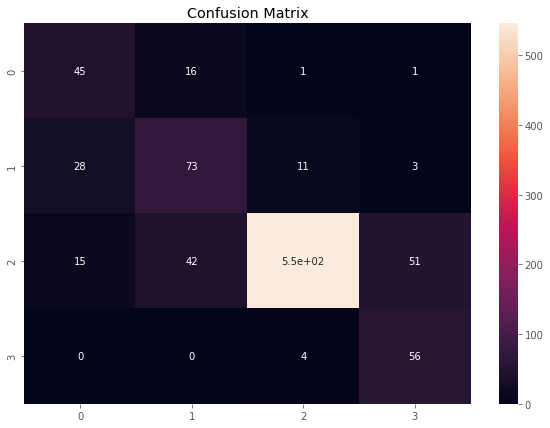

In [36]:
show_metrics(third_metrics)
plot_confusion(third_model['model'])